In [1]:
import discretisedfield as df  # df is here chosen to be an alias for discretisedfield

p1 = (0, 0, 0)
p2 = (100e-9, 50e-9, 20e-9)

region = df.Region(p1=p1, p2=p2)

In [2]:
import pyvista as pv

pv.set_jupyter_backend("trame")

In [3]:
region.pyvista()

Widget(value="<iframe src='http://localhost:43059/index.html?ui=P_0x7fc460633ee0_0&reconnect=auto' style='widt…

In [23]:
import numpy as np
import pyvista as pv
import ubermagutil.units as uu

import discretisedfield.plotting.util as plot_util


class PyVistaMesh:
    def __init__(self, mesh):
        if mesh.region.ndim != 3:
            raise RuntimeError("Only 3d meshes can be plotted.")
        self.mesh = mesh

    def __call__(
        self, *, plot=None, color=plot_util.cp_int[:2], multiplier=None, **kwargs
    ):
        if self.mesh.region.ndim != 3:
            raise RuntimeError(
                "Only meshes with 3 spatial dimensions can be plotted not"
                f" {self.data.mesh.region.ndim=}."
            )

        if plot is None:
            plotter = pv.Plotter()

        multiplier = self._setup_multiplier(multiplier)

        rescaled_mesh = self.mesh.scale(1 / multiplier, reference_point=(0, 0, 0))

        values = np.ones(rescaled_mesh.n)
        values[0, 0, -1] = 2  # mark the discretisation cell

        grid = pv.RectilinearGrid(*rescaled_mesh.vertices)
        grid.cell_data["values"] = values.flatten(order="F")

        plotter.add_mesh(grid, scalars="values", show_edges=True, **kwargs)
        label = self._axis_labels(multiplier)
        # Bounds only needed due to axis bug
        bounds = tuple(
            val
            for pair in zip(rescaled_mesh.region.pmin, rescaled_mesh.region.pmax)
            for val in pair
        )
        box = pv.Box(bounds)
        plotter.add_mesh(box, opacity=0.0)
        plotter.show_grid(xtitle=label[0], ytitle=label[1], ztitle=label[2])
        if plot is None:
            plotter.show()

    def subregions(
        self, *, plot=None, color=plot_util.cp_hex, multiplier=None, **kwargs
    ):
        if self.mesh.region.ndim != 3:
            raise ValueError(
                "Only meshes with 3 spatial dimensions can be plotted not"
                f" {self.data.mesh.region.ndim=}."
            )

        if plot is None:
            plotter = pv.Plotter()

        multiplier = self._setup_multiplier(multiplier)

        rescaled_mesh = self.mesh.scale(1 / multiplier, reference_point=(0, 0, 0))

        for i, (key, subregion) in enumerate(rescaled_mesh.subregions.items()):
            subregion.pyvista(plot=plotter, color=color[i], label=key)

        grid = pv.RectilinearGrid(*rescaled_mesh.vertices)
        plotter.disable_hidden_line_removal()
        plotter.add_mesh(grid, style="wireframe", show_edges=True, **kwargs)
        label = self._axis_labels(multiplier)
        # Bounds only needed due to axis bug
        bounds = tuple(
            val
            for pair in zip(rescaled_mesh.region.pmin, rescaled_mesh.region.pmax)
            for val in pair
        )
        box = pv.Box(bounds)
        plotter.add_mesh(box, opacity=0.0)
        plotter.show_grid(xtitle=label[0], ytitle=label[1], ztitle=label[2])

        plotter.add_legend()
        if plot is None:
            plotter.show()

    def _setup_multiplier(self, multiplier):
        return self.mesh.region.multiplier if multiplier is None else multiplier

    def _axis_labels(self, multiplier):
        return [
            rf"{dim} ({uu.rsi_prefixes[multiplier]}{unit})"
            for dim, unit in zip(self.mesh.region.dims, self.mesh.region.units)
        ]

In [24]:
lx, ly, lz = 100e-9, 50e-9, 20e-9

subregions = {
    "bottom_subregion": df.Region(p1=(20e-9, 0, 0), p2=(40e-9, 50e-9, 10e-9)),
    "top_subregion": df.Region(p1=(80e-9, 40e-9, lz / 2), p2=(lx, ly, lz)),
}

cell = (5e-9, 5e-9, 5e-9)

region = df.Region(p1=(0, 0, 0), p2=(lx, ly, lz))
mesh = df.Mesh(region=region, cell=cell, subregions=subregions)

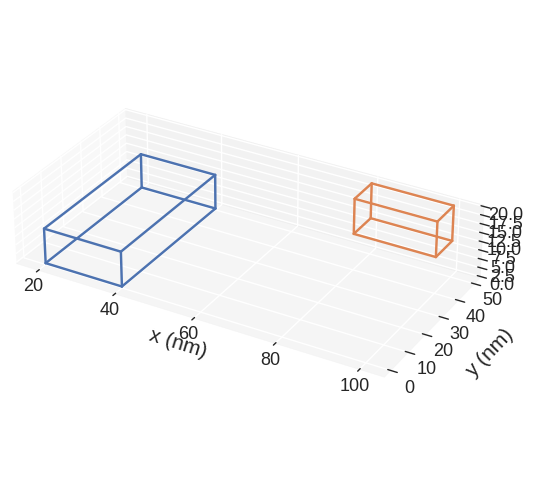

In [25]:
mesh.mpl.subregions()

In [26]:
PyVistaMesh(mesh)()

Widget(value="<iframe src='http://localhost:43059/index.html?ui=P_0x7fc35c55f370_8&reconnect=auto' style='widt…

In [27]:
PyVistaMesh(mesh).subregions()

Widget(value="<iframe src='http://localhost:43059/index.html?ui=P_0x7fc35c5c5940_9&reconnect=auto' style='widt…